# Volume 4: Poisson's Equation
    Benj McMullin
    Math 439
    1/10/2024

In [1]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import scipy.linalg as la
import matplotlib.pyplot as plt
import imageio
from mpl_toolkits.mplot3d import Axes3D

# Problem 1

Complete the function `poisson_square` by implementing the finite difference method given in the lab. Use `scipy.sparse.linalg.spsolve` to solve the linear system. Use your function to solve the boundary value problem:

\begin{align}
	\Delta u = 0, &{}\quad x \in [0,1]\times [0,1],\\
	u(x,y) = x^3, &{}\quad (x,y) \in \partial ([0,1]\times [0,1])
\end{align}

Use $n=100$ subintervals for both $x$ and $y$. Plot the solution as a 3D surface.

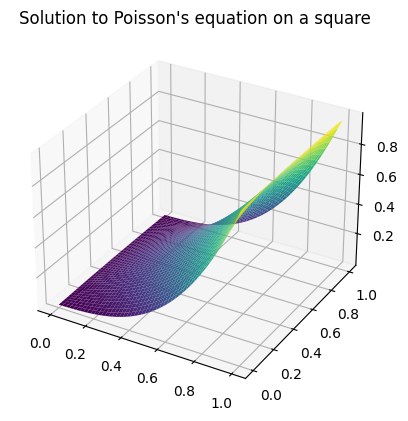

In [3]:
def poisson_square(a, b, c, d, n, f, g):
    """
    Computes the finite difference method for the Poisson equation boundary-value
    problem on a square:

    Parameters:
        a (float): Left-hand boundary for x.
        b (float): Right-hand boundary for x.
        c (float): Lower boundary for y.
        d (float): Upper boundary for y.
        f (function): Right-hand side of the PDE.
        g (function): Boundary condition.
        n (int): Number of subintervals.
    
    Returns:
        U (ndarray of shape (n+1, n+1)): Approximate solution.
    """
    
    # Generate grid points and step sizes
    x, dx = np.linspace(a, b, n + 1, retstep = True)
    y = np.linspace(c, d, n + 1)

    # Construct the sparse matrix for the Laplacian operator
    sparse_matrix = sp.diags([-4 * np.ones(n - 1), np.ones(n - 2), np.ones(n - 2)], [0, -1, 1])

    # Create block diagonal matrix A
    matrix_A = sp.block_diag([sparse_matrix] * (n - 1))

    # Assemble the complete coefficient matrix
    matrix_A = (matrix_A + sp.diags([np.ones((n - 1) * (n - 2))], [-(n - 1)]) +
                sp.diags([np.ones((n - 1) * (n - 2))], [n - 1])) / (dx ** 2)

    # Generate the matrix p
    p = np.array([[g(x[i], y[j]) if i == 0 else g(x[-1], y[j]) if i == (n - 2) else 0 for i in range(n - 1)] / (dx ** 2)
                   for j in range(1, n)])

    # Generate the matrices q_1, q_2, and q_3
    q_1 = [g(x[i], y[0]) for i in range(1, n)] / dx ** 2
    q_2 = [g(x[i], y[n]) for i in range(1, n)] / dx ** 2
    q_3 = np.vstack(([np.zeros(n - 1)] * (n - 3)))
    q = np.vstack((q_1, q_3, q_2))

    # Generate the matrix f
    f = np.array([[f(x[i], y[j]) for i in range(1, n)] for j in range(1, n)])

    # Assemble the right-hand side vector b
    b = f - p - q

    # Solve the linear system using sparse solver
    U = spla.spsolve(matrix_A, np.ravel(b))
    U = np.reshape(U, (n - 1, n - 1))

    return U

# Define functions and parameters for the example
f1 = lambda x, y: 0
g1 = lambda x, y: x ** 3
n1 = 100

# Solve Poisson's equation on a square
U = poisson_square(a = 0, b = 1, c = 0, d = 1, f = f1, g = g1, n = n1)

# Plot the solution in 3D
x = np.linspace(0, 1, n1 - 1)
y = np.linspace(0, 1, n1 - 1)
X, Y = np.meshgrid(x, y)
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.plot_surface(X, Y, U, cmap = 'viridis')
plt.title("Solution to Poisson's equation on a square")
plt.show()

# Problem 2

Solve 

\begin{align}
	\Delta V = -\rho(x,y), &{}\quad x \in [-2,2]\times [-2,2],\\
	u(x,y) = 0, &{}\quad (x,y) \in \partial ([-2,2]\times [-2,2]).
\end{align}

for the electric potential $V.$ Use the source function defined above, such that $\rho(x,y) = \text{source}(x,y)$. Use $n=100$ subintervals for $x$ and $y$. Use the provided code to plot your solution.

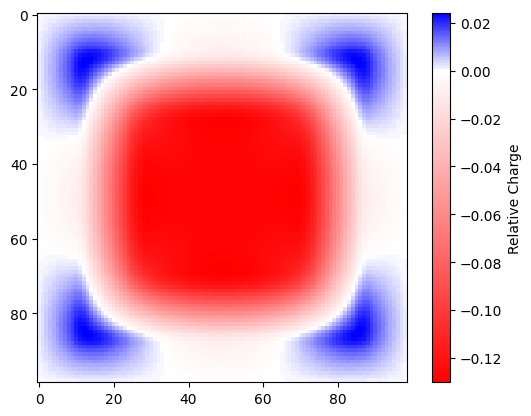

In [6]:
import matplotlib.colors as mcolors

def source(X,Y):
    """
    Takes arbitrary arrays of coordinates X and Y and returns an array of the same shape
    representing the charge density of nested charged squares
    """
    src = np.zeros(X.shape)
    src[ np.logical_or(np.logical_and( np.logical_or(abs(X-1.5) < .1,abs(X+1.5) < .1) ,abs(Y) <  1.6),
    np.logical_and( np.logical_or(abs(Y-1.5) < .1,abs(Y+1.5) < .1) ,abs(X) <  1.6))] = 1
    
    src[ np.logical_or(np.logical_and( np.logical_or(abs(X-0.9) < .1,abs(X+0.9) < .1) ,abs(Y) <  1.0),
    np.logical_and( np.logical_or(abs(Y-0.9) < .1,abs(Y+0.9) < .1) ,abs(X) <  1.0))] = -1
    return src
    
#Generate a color dictionary for use with LinearSegmentedColormap
#that places red and blue at the min and max values of data
#and white when data is zero
def genDict(data):
    zero = 1/(1 - np.max(data)/np.min(data))
    cdict = {
    'red': [(0.0, 1.0, 1.0),(zero, 1.0, 1.0),(1.0, 0.0, 0.0)],
    'green': [(0.0, 0.0, 0.0),(zero, 1.0, 1.0),(1.0, 0.0, 0.0)],
    'blue': [(0.0, 0.0, 0.0),(zero, 1.0, 1.0),(1.0, 1.0, 1.0)]
    }
    return cdict

a1 = -2.
b1 = 2.
c1 = -2.
d1 = 2.
n =100
X = np.linspace(a1,b1,n)
Y = np.linspace(c1,d1,n)
X,Y = np.meshgrid(X,Y)

# Initialize the source function and boundary conditions
f = lambda x,y: -1 * source(x,y)
g = lambda x,y: 0

# Solve Poisson's equation on a square
U = poisson_square(a = a1, b = b1, c = c1, d = d1, f = f, g = g, n = n)

# Plot the solution
plt.imshow(U,cmap = mcolors.LinearSegmentedColormap('cmap', genDict(U)))
plt.colorbar(label="Relative Charge")
plt.show()

# Problem 3
Using the data file dr_jarvis.jpg as the source image $v$ and mount_rushmore.jpg as the destination image $u_0$, put Dr. Jarvis' face on Mount Rushmore. Use the finite difference Laplacian operator to calculate $f$ from $v$ .

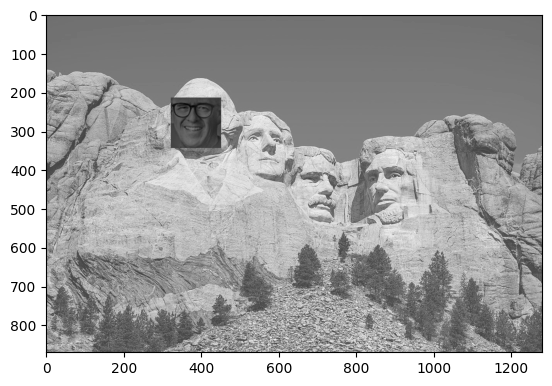

In [9]:
source = np.mean(imageio.v3.imread('dr_jarvis.jpg'), axis=2).transpose() /255
dest = np.mean(imageio.v3.imread('mount_rushmore.jpg'), axis=2).transpose() / 255

w = 130 # width and height to crop out.
x0s = 60 # position in source image
y0s = 84
x0 = 322 # position in destination image
y0 = 215
image = source[x0s-1:x0s+w+1,y0s-1:y0s+w+1]*0.58    # source image with a buffer of 1 pixel for the finite difference method.
                                                    # The buffer will need to be removed before inserting into the Mount
                                                    # Rushmore image. The '*0.58' will make it look better when displayed
        
# code to calculate f, and then the solution u
# ...

# Calculate finite difference matrix and solve for the new image
Df = ((image[2:, :] - 2 * image[1:-1, :] + image[:-2, :])[:, 1:-1] +
              (image[:, 2:] - 2 * image[:, 1:-1] + image[:, :-2])[1:-1, :])

T = sp.diags([1, -4, 1], [-1, 0, 1], shape=(w, w))
A = sp.block_diag([T] * (w))

A.setdiag(1, k=w)
A.setdiag(1, k=-w)
A_csr = A.tocsr()

u = spla.spsolve(A_csr, Df.ravel())

# Create a new image by combining the destination image and the solved region
image = dest.copy()
image[x0:x0 + w, y0:y0 + w] = u.reshape(w, w)

# Display the resulting image
plt.imshow(image.transpose(), cmap = 'gray')
plt.show()